In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import warnings
from scipy.stats import norm

import sys
sys.path.append('../')
import src as src

In [2]:
import scipy as sp
import pandas as pd

## Markov Chains

In [3]:
mc = src.MarkovChain(np.array([[0.99,0.01],[0.2,0.8]]),np.array([0,1]))
mc.iterate(1, set_state=True)
mc.state_vector
mc.transition_matrix
mc.forecast([5,1,7,123,45,0])

array([[0.72086909, 0.27913091],
       [0.358     , 0.642     ],
       [0.8078944 , 0.1921056 ],
       [0.95238095, 0.04761905],
       [0.95236235, 0.04763765],
       [0.2       , 0.8       ]])

In [4]:
mc.iterate(2)

../src/markov.py:117: UserWarning: state vector probabilities rounded to 8 digits
  warnings.warn('state vector probabilities rounded to 8 digits')


In [5]:
mc.steady_state()

array([0.95238095, 0.04761905])

In [6]:
mc.expected_durations()

array([100.,   5.])

In [7]:
mc.entropy()

array(0.72192809)

## Distributions

In [8]:
fac1 = src.NormalDistribution(1.1, 2)
fac2 = src.NormalDistribution(1.1, 5)
factors = [fac1, fac2]

In [9]:
isinstance(fac1, src.BaseDistribution)

True

In [10]:
isinstance(fac1, src.NormalDistribution)

True

In [11]:
src.ProductDistribution(factors).mean(), np.array(src.ProductDistribution(factors).rvs(100000)).mean()

(1.2100000000000002, 1.1673341999706233)

In [12]:
src.ProductDistribution(factors).std(), np.array(src.ProductDistribution(factors).rvs(100000)).std()

(11.62282237668631, 11.608008080349398)

In [13]:
import scipy as sp
(src.ProductDistribution(factors).skew(), sp.stats.skew(src.ProductDistribution(factors).rvs(100000)))

(0.46238295716396305, 0.3792500109775284)

In [14]:
(src.ProductDistribution(factors).kurt(), sp.stats.kurtosis(src.ProductDistribution(factors).rvs(1000000)))

(5.595171030073189, 5.5163154846846965)

## Models

In [15]:
src.NormalModel(mu=0, sigma=1).pdf(2)

0.05399096651318806

In [16]:
mm = src.MixtureModel()

## HMM Model

In [17]:
mdls = (src.NormalModel(0.8,0.2), src.NormalModel(1.2,1))
hmm = src.HiddenMarkovModel(transition_matrix=np.array([[0.99,0.01],[0.2,0.8]]), state_vector=[0.5,0.5], emission_models=mdls)
#hmm.mixture_distribution()
hmm.emission_models

(<src.models.NormalModel at 0x7f1369362c88>,
 <src.models.NormalModel at 0x7f1369362cc0>)

In [18]:
hmm.iterate(2).state_vector

array([[0.67005, 0.32995]])

In [19]:
hmm.iterate(2).exkurt()

1.4139433130576027

In [20]:
hmm.iterate(2).entropy()

0.9148752798696143

In [21]:
## add product distribution moments

<AxesSubplot:>

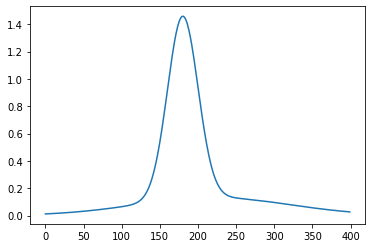

In [22]:
pd.Series(hmm.iterate(2).pdf(np.arange(-1,3,0.01))).plot()

In [38]:
comps = [(src.NormalDistribution(0,1), 0.5), (src.NormalDistribution(1,1), 0.5)]
mix = src.MixtureDistribution(comps)

In [46]:
mdls = [src.NormalModel(0,1), src.NormalModel(1,1)]
Y = sp.stats.norm(0.5,2).rvs(100)
hmm = src.HiddenMarkovModel(emission_models=mdls)
hmm.fit(Y)
hmm.component_stds()
hmm.transition_matrix

array([[0.482821, 0.517179],
       [0.471501, 0.528499]])

In [36]:
m = src.MarkovChain()
hasattr(m, 'transition_matrix')


True

In [ ]:
np.full(2, 1).

In [ ]:
from src import BaseDistribution
isinstance(mdls[0][0], BaseDistribution)

In [ ]:
nd = src.NormalDistribution(0,1)
isinstance(nd, src.BaseDistribution)

In [ ]:
hmm.components

In [ ]:
Y = sp.stats.norm(0.5,2).rvs(10)
print(hmm.emission_models[0].mu, hmm.emission_models[1].mu)
print(hmm.emission_models[0].sigma, hmm.emission_models[1].sigma)
print(hmm.state_vector)
hmm._estimate_baum_welch(Y, max_iter=100, return_fit=True)

In [ ]:
hmm.fit(Y)

In [ ]:
hmm.component_means()

In [ ]:
hmm.state_vector

In [ ]:
hmm.smooth_prob_#.shape

In [ ]:
mdls = (src.NormalModel(0,1), src.NormalModel(1,1))
hmm = src.HiddenMarkovModel(transition_matrix=np.array([[0.99,0.01],[0.2,0.8]]), state_vector=[0.5,0.5], emission_models=mdls)

In [ ]:
hmm.mixture_distribution

In [ ]:
hmm.markov_chain.iterate(2)

In [ ]:
hmm.distribution

In [ ]:
hmm.iterate(12)

In [ ]:
import pandas as pd

In [ ]:
Y = sp.stats.norm(2,5).rvs(1000)
print(hmm.component_means(), hmm.component_stds())
hmm, fit = hmm._estimate_baum_welch(Y, max_iter=500, return_fit=True)
print(fit['converged'])
print(hmm.transition_matrix)
pd.Series(fit['scores']).plot()

In [ ]:
pd.Series(hmm.distribution.pdf(np.arange(-8,8,0.1))).plot()

In [ ]:
hmm.iterate(1)

## Other Simulation

In [ ]:
sample_1 = pd.DataFrame(sp.stats.multivariate_normal(mean=[1.1, 1.1], cov=[[0.2, 0.1],[0.1, 0.2]]).rvs(10000))

In [ ]:
sample_1.corr()

In [ ]:
sample_1.cov()

In [ ]:
l = 20
_ = pd.DataFrame(sp.stats.multivariate_normal(mean=[1.1, 1.1], cov=[[0.2, 0.1],[0.1, 0.2]]).rvs(10000*l))
sample_2 = _.groupby(_.index // l).prod()

In [ ]:
sample_2.corr()

In [ ]:
sample_2.cov()